![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

# Uniaxial stress relaxation on dual creep law

Shows basic capabilities of new creep model that includes dislocation creep (power law) and pressure-solution creep (linear law).

\begin{align}
\dot { \boldsymbol \epsilon}^\text{cr}&={\color{black} {\sqrt{\frac{3}{2}}}}A_1e^{-Q_1/(RT)}\left(\dfrac{{\bar \sigma}}{\sigma_\text{ref}}\right)^m\dfrac{{\mathbf s}}{{\left\Vert{\mathbf s}\right\Vert}} + {\color{black} {\sqrt{\frac{3}{2}}}}\frac{A_2}{D^3}e^{-Q_2/(RT)}\left(\dfrac{{\bar \sigma}}{\sigma_\text{ref}}\right)\dfrac{{\mathbf s}}{{\left\Vert{\mathbf s}\right\Vert}}
\\
&={\color{black} {\sqrt{\frac{3}{2}}}}A_1e^{-Q_1/(RT)}\left(\dfrac{{\bar \sigma}}{\sigma_\text{ref}}\right)^m\dfrac{{\mathbf s}}{{\left\Vert{\mathbf s}\right\Vert}} + {\color{black} {\frac{3}{2}}}\frac{A_2}{\sigma_\text{ref}D^3}e^{-Q_2/(RT)} \mathbf{s}
\end{align}

Parameters in all tests are qualitative.

In [1]:
#HIDDEN
import mtest
import numpy as np
import matplotlib.pyplot as plt
import os
import plot_settings
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)

In [2]:
A1 = 0.18
Q1 = 54e3
E = 25e3
m1 = 5
nu = 0.27

A2 = 0.
Q2 = 54e3
sref = 1.
Dgrain = 5e-3

In [3]:
build_release = 'mfront --obuild --interface=generic PowerLawLinearCreep.mfront'
os.system(build_release)

0

In [4]:
#HIDDEN
def run_temp_sim_BGRa(t_discrete, T0=293.15):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'PowerLawLinearCreep')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStrain('EZZ', -0.01)
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PowerLawFactor', A1)
    m.setMaterialProperty('PowerLawEnergy', Q1)
    m.setMaterialProperty('PowerLawExponent', m1)
    m.setMaterialProperty('LinearLawFactor', A2)
    m.setMaterialProperty('LinearLawEnergy', Q2)
    m.setMaterialProperty('ReferenceStress', sref)
    m.setMaterialProperty('SaltGrainSize', Dgrain)
    m.setExternalStateVariable("Temperature", T0)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.s1[2])
    return numerical

In [5]:
#HIDDEN
times = np.linspace(0,100,1000)

## Stress relaxation of BGRa

Simple test of dislocation creep of sample exposed to instantaneous uniaxial compression of 1 %.

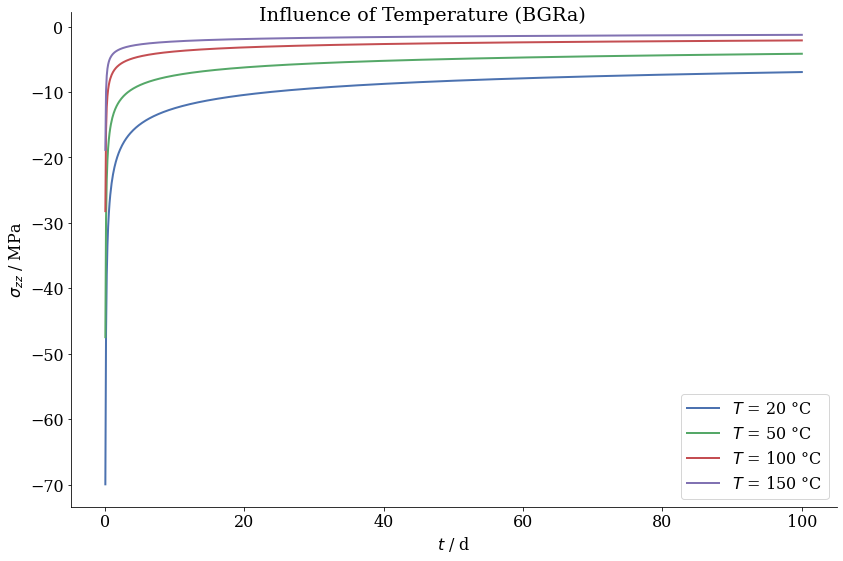

In [6]:
#HIDDEN
temps = [20,50,100,150]
fig,ax = plt.subplots(figsize=(12,8))
for Temp in temps:
    ax.plot(times[1:],run_temp_sim_BGRa(times,273.15+Temp)[1:],label='$T$ = %i °C' %Temp)
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\sigma_{zz}$ / MPa')
fig.tight_layout();
fig.suptitle('Influence of Temperature (BGRa)')
ax.legend();

In [7]:
#HIDDEN
def run_grain_sim_PLL(t_discrete, D=5e-3):
    Dgrain = D
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'PowerLawLinearCreep')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStrain('EZZ', -0.01)
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PowerLawFactor', A1)
    m.setMaterialProperty('PowerLawEnergy', Q1)
    m.setMaterialProperty('PowerLawExponent', m1)
    m.setMaterialProperty('LinearLawFactor', A1/1e3)
    m.setMaterialProperty('LinearLawEnergy', Q1)
    m.setMaterialProperty('ReferenceStress', sref)
    m.setMaterialProperty('SaltGrainSize', Dgrain)
    m.setExternalStateVariable("Temperature", 393.15)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.s1[2])
    return numerical

## Isothermal test of dislocation and pressure-solution creep

Simple stress relaxation test of sample exposed to instantaneous uniaxial compression of 1 %. Grain size is varied to demonstrate impact of pressure-solution creep at low stresses.

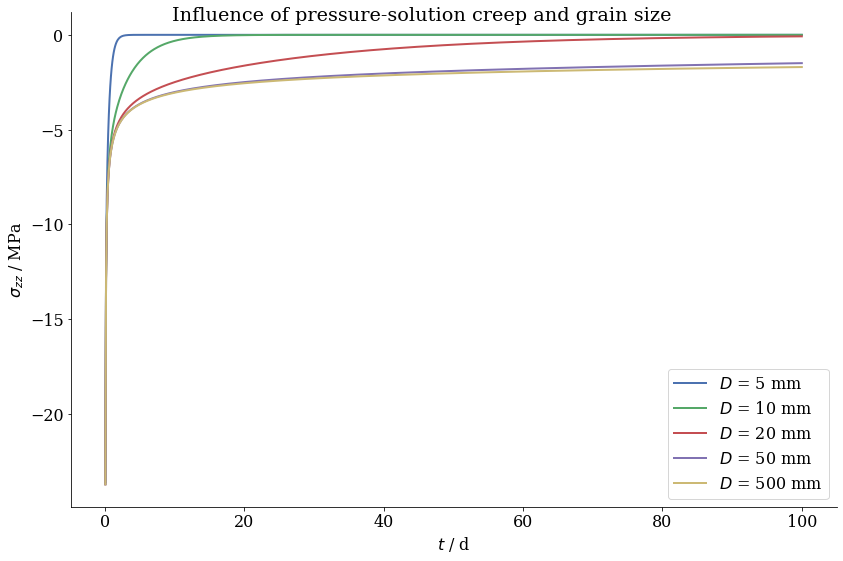

In [8]:
#HIDDEN
Ds = [5e-3,1e-2,2e-2,5e-2,5e-1]
fig,ax = plt.subplots(figsize=(12,8))
for d in Ds:
    ax.plot(times[1:],run_grain_sim_PLL(times,d)[1:],label='$D$ = %i mm' %(d*1e3))
ax.set_xlabel('$t$ / d')
ax.set_ylabel('$\\sigma_{zz}$ / MPa')
fig.tight_layout();
fig.suptitle('Influence of pressure-solution creep and grain size')
ax.legend();

In [19]:
#HIDDEN
def run_stress_effect_sim(t_discrete, sax, T):
    m    = mtest.MTest()
    m.setMaximumNumberOfSubSteps(1)
    m.setBehaviour('generic', './src/libBehaviour.so', 'PowerLawLinearCreep')
    m.setImposedStress('SXX', 0.0)
    m.setImposedStress('SYY', 0.0)
    m.setImposedStress('SZZ', sax)
    m.setImposedStress('SXZ', 0.0)
    m.setImposedStress('SYZ', 0.0)
    m.setImposedStress('SXY', 0.0)
    m.setMaterialProperty('YoungModulus', E)
    m.setMaterialProperty('PoissonRatio', nu)
    m.setMaterialProperty('PowerLawFactor', A1)
    m.setMaterialProperty('PowerLawEnergy', Q1)
    m.setMaterialProperty('PowerLawExponent', 5)
    m.setMaterialProperty('LinearLawFactor', A1/1e3)
    m.setMaterialProperty('LinearLawEnergy', Q1)
    m.setMaterialProperty('ReferenceStress', sref)
    m.setMaterialProperty('SaltGrainSize', 2e-2)
    m.setExternalStateVariable("Temperature", T)
    s = mtest.MTestCurrentState()
    wk = mtest.MTestWorkSpace()
    m.completeInitialisation()
    m.initializeCurrentState(s)
    m.initializeWorkSpace(wk)
    numerical = np.array([0.])
    prev = np.array([0.])
    for i in range(len(t_discrete)-1):
        m.execute(s, wk, t_discrete[i], t_discrete[i + 1])
        numerical = np.append(numerical,s.e1[2])
        prev = np.append(prev,s.e0[2])
    return numerical, prev

## Impact of temperature and deviatoric stress on creep rate

This test shows importance of pressure-solution creep in low-stress environments and dominance of dislocation creep at high stresses. Temperature increase increases both strain rates.

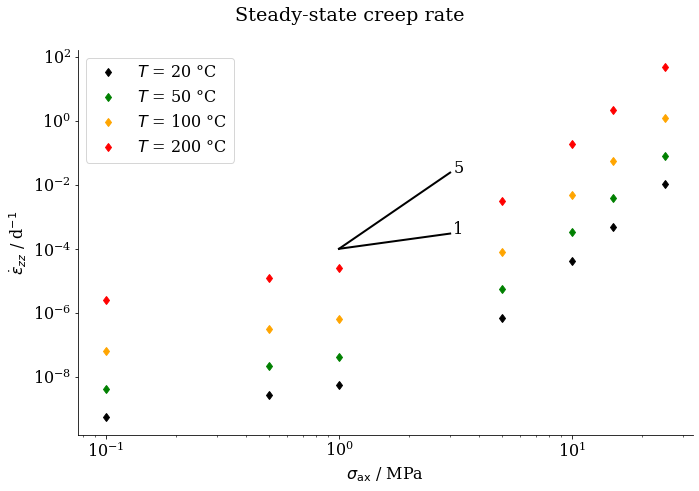

In [20]:
#HIDDEN
sax = [0.1,0.5,1,5,10,15,25]
temps = [20,50,100,200]
cols = ['black','green','orange','red']
fig,ax = plt.subplots(figsize=(10,7))
for s in sax:
    for i,T in enumerate(temps):
        eps1, eps0 = run_stress_effect_sim(times,s,T+273.15)
        dot_eps_av = np.mean((eps1[2:]-eps0[2:])/(times[1] - times[0]))
        if s == sax[0]:
            ax.plot(s,dot_eps_av,label='$T$ = %i °C' %T, ls='', marker='d',color=cols[i])
        else:
            ax.plot(s,dot_eps_av, ls='', marker='d',color=cols[i])
ax.plot([1,3],[1e-4,(3**5)*1e-4],ls='-',color='black')#5
ax.plot([1,3],[1e-4,3e-4],ls='-',color='black')#1
ax.text(3.1,(3**5)*1e-4,'5')
ax.text(3.1,3e-4,'1')
ax.set_xlabel('$\\sigma_\\mathrm{ax}$ / MPa')
ax.set_ylabel('$\\dot{\\epsilon}_{zz}$ / d$^{-1}$')
ax.set_xscale('log')
ax.set_yscale('log')
fig.suptitle('Steady-state creep rate')
ax.legend();
fig.tight_layout();
fig.savefig('creep_transition.pdf')